Image shape at 10 m resolution: (1228, 1312) pixels
[array([[[85, 11, 15,  7],
        [87, 10, 14,  7],
        [85, 11, 14,  6],
        ...,
        [65,  9, 12,  4],
        [68, 10, 11,  6],
        [73, 11, 14,  5]],

       [[87, 11, 15,  7],
        [89, 10, 15,  7],
        [88, 11, 14,  5],
        ...,
        [70, 10, 11,  5],
        [75, 11, 13,  6],
        [75, 10, 14,  5]],

       [[93, 11, 15,  6],
        [96, 11, 15,  7],
        [92, 10, 14,  5],
        ...,
        [76, 11, 13,  6],
        [73, 10, 12,  5],
        [75, 10, 13,  5]],

       ...,

       [[74, 14, 17,  9],
        [79, 14, 19, 12],
        [81, 14, 17, 11],
        ...,
        [95, 18, 22, 12],
        [97, 15, 21, 13],
        [92, 12, 17,  9]],

       [[70, 14, 17, 10],
        [70, 14, 17, 11],
        [72, 13, 16,  9],
        ...,
        [94, 18, 20, 11],
        [92, 17, 21, 11],
        [84, 13, 17,  9]],

       [[73, 14, 18, 11],
        [74, 14, 16, 11],
        [68, 14, 15,  9],
 

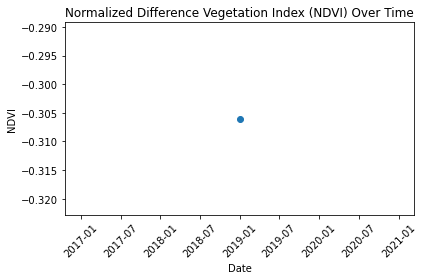

[datetime.datetime(2019, 1, 1, 0, 0)]
[-0.30603078]


In [89]:
import os
from datetime import datetime
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from rasterio.transform import Affine
from sentinelhub import SHConfig, BBox, CRS, DataCollection, SentinelHubRequest, MimeType, bbox_to_dimensions, SentinelHubDownloadClient

# Set Sentinel Hub credentials
config = SHConfig()
config.sh_client_id = ''
config.sh_client_secret = ''

# Function to download Sentinel satellite images
def download_images(bbox, time_interval, output_folder, resolution=10, satellite='SENTINEL_2A', cloud_cover=10):
    
    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)
    
    for start_date, end_date in time_interval:
        bbox_obj = BBox(bbox, CRS.WGS84)
        dwn_size = bbox_to_dimensions(bbox_obj, resolution=resolution)
        print(f"Image shape at {resolution} m resolution: {dwn_size} pixels")
        
        request = SentinelHubRequest(
            evalscript='''//VERSION=3
                function setup() {
                    return {
                        input: ["B02", "B03", "B04", "B08"],
                        output: { bands: 4 }
                    };
                }

                function evaluatePixel(sample) {
                    return [ sample.B08, sample.B04, sample.B03, sample.B02 ];
                }
            ''',
            input_data=[
                SentinelHubRequest.input_data(
                    data_collection=DataCollection.SENTINEL2_L2A,
                    time_interval=("2019-01-01", "2024-04-01"),
                    other_args={
                        "dataFilter": {         
                        'maxCloudCoverage': cloud_cover,
                        'resolution': f'{resolution}m',
                        'satellite': satellite}
                    }
                )
            ],
            responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
            bbox=bbox_obj,
            size=dwn_size,
            config=config
        )
        
        # Get the data
        data = request.get_data()
        print(data)

        # Save the images
        for idx, image_data in enumerate(data):
            print(image_data)
            image_filename = f'{start_date}_{end_date}_{idx}.tif'
            image_filepath = os.path.join(output_folder, image_filename)

            # Write the image data to a GeoTIFF file using rasterio
            with rasterio.open(image_filepath, 'w', driver='GTiff', width=image_data.shape[1], height=image_data.shape[0],
                               count=image_data.shape[2], dtype=str(image_data.dtype), crs='EPSG:4326',
                               transform=Affine.translation(bbox_obj.min_x, bbox_obj.max_y) * Affine.scale(resolution, -resolution)) as dst:
                # Write the data from all bands
                for i in range(image_data.shape[2]):
                    dst.write(image_data[:, :, i], indexes=i+1)


# Function to calculate NDVI statistics
def calculate_ndvi_stats(image_path):
    with rasterio.open(image_path) as src:
        red = src.read(3).astype('f4')
        nir = src.read(4).astype('f4')

    ndvi = (nir - red) / (nir + red)
    ndvi_mean = np.nanmean(ndvi)
    ndvi_median = np.nanmedian(ndvi)
    ndvi_max = np.nanmax(ndvi)
    ndvi_min = np.nanmin(ndvi)

    return ndvi_mean, ndvi_median, ndvi_max, ndvi_min

# Function to plot NDVI over time
def plot_ndvi_over_time(ndvi_stats, dates):
    plt.plot(dates, ndvi_stats, marker='o')
    plt.xlabel('Date')
    plt.ylabel('NDVI')
    plt.title('Normalized Difference Vegetation Index (NDVI) Over Time')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Main function
def main():
    # User inputs
    aoi_bbox = (-1.821087,5.567851,-1.709975,5.686242)
    start_date = '2019-01-01'  # Start date for image acquisition
    end_date = '2024-04-01'  # End date for image acquisition
    output_folder = 'output_images'  # Output folder to save downloaded images
    resolution = 10  # Resolution in meters
    #satellite = 'Sentinel-2A'  # Satellite type
    cloud_cover = 10  # Maximum cloud cover percentage

    # Download images
    download_images(aoi_bbox, [(start_date, end_date)], output_folder, resolution, cloud_cover)

    # Calculate NDVI statistics
    ndvi_stats = []
    dates = []
    for root, _, files in os.walk(output_folder):
        for file in files:
            if file.endswith('.tif'):
                image_path = os.path.join(root, file)
                ndvi_mean, _, _, _ = calculate_ndvi_stats(image_path)
                ndvi_stats.append(ndvi_mean)
                dates.append(datetime.strptime(file[:10], '%Y-%m-%d'))

    # Plot NDVI over time
    plot_ndvi_over_time(ndvi_stats, dates)
    print(dates)
    print(ndvi_stats)



main()


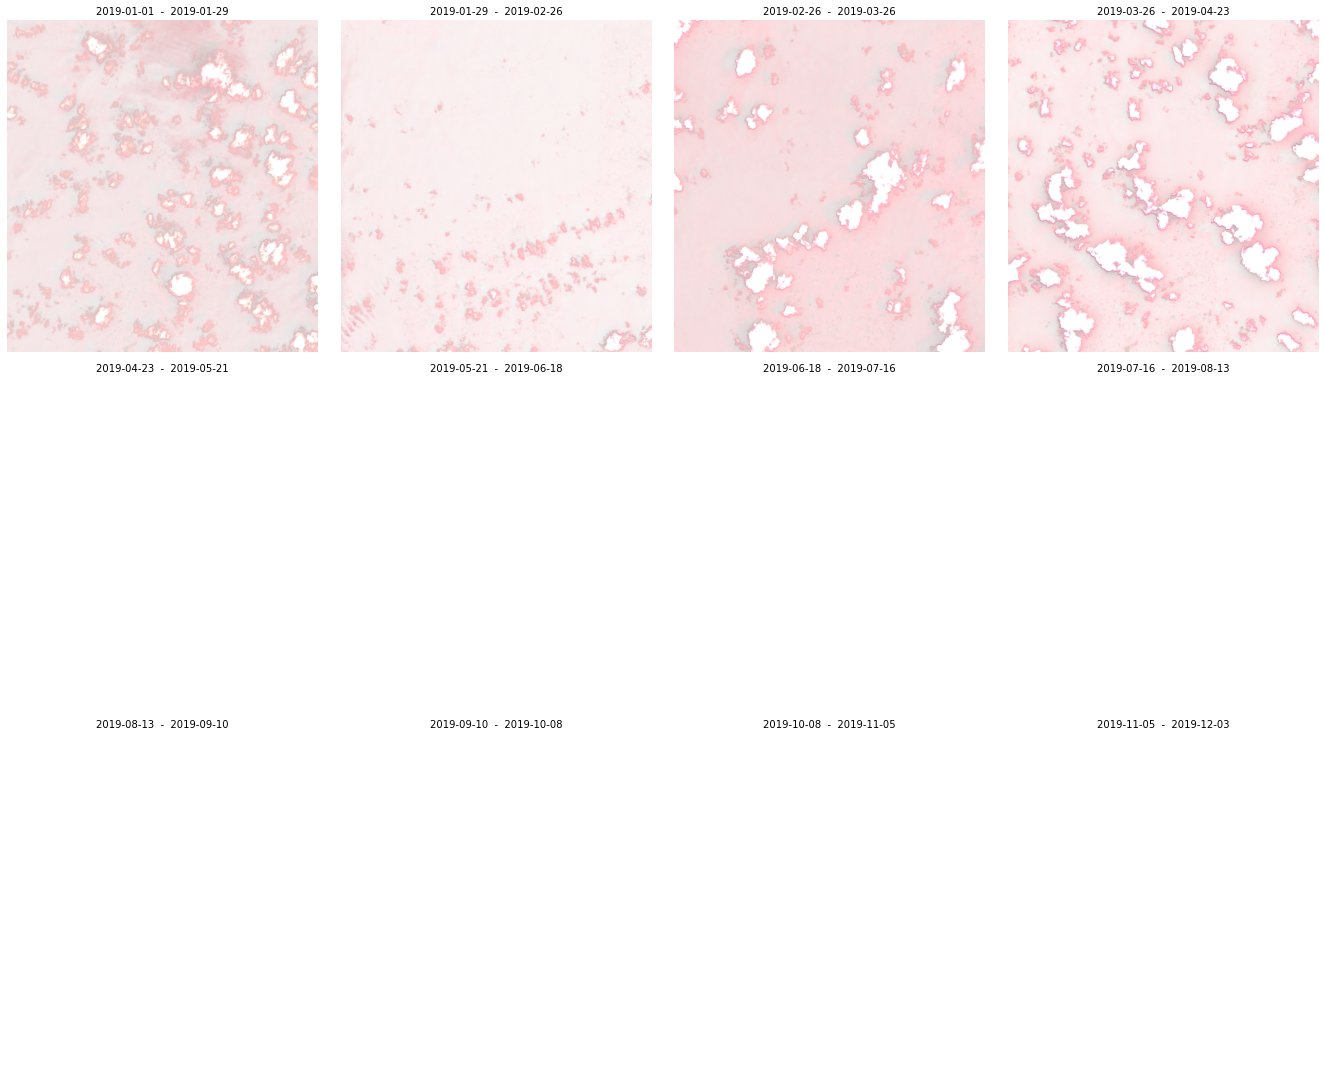

In [69]:
# # plotting
# ncols = 4
# nrows = 3
# aspect_ratio = dwn_size[0] / dwn_size[1]
# subplot_kw = {"xticks": [], "yticks": [], "frame_on": False}

# fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5 * ncols * aspect_ratio, 5 * nrows), subplot_kw=subplot_kw)

# for idx, image in enumerate(data):
#     ax = axs[idx // ncols][idx % ncols]
#     ax.imshow(np.clip(image * 2.5 / 255, 0, 1))
#     ax.set_title(f"{slots[idx][0]}  -  {slots[idx][1]}", fontsize=10)

# plt.tight_layout()